# Project Description

The following project deals with Mining Association rules from a sales transaction database. 
The database contains baskets (lists) of items that have been bought together (eg. supermarket items).

What we did was:
1. Find frequent itemsets using the A-Priori algorithm for efficient search, and store the ones with sufficient support s.
2. Mine association rules from the frequent itemsets, and keep the ones with a sufficient confidence level c. 

We define the support count of an itemset as the number of baskets in which the itemset appears. A rule is instead an implication of the type X -> Y, where X∩Y=∅ and its confidence is the fraction of transactions containing X⋃Y in all transactions that contain X.

## A-Priori algorithm

The A-Priori algorithm consists in a memory efficient way of finding frequent itemsets in the dataset. Here is how it works for detecting frequent itemsets of various length k until k_max:
1. In the first pass, count all the times every single element occurs and store them in C1
2. Keep only the elements that have a support higher than a threshold s, storing them in L1
3. In the second pass, for each basket, count the occurence of all the pairs of items who have both elements in L1 (storing them in C2).
4. Of these, keep only the ones with support larger than s (L2)
5. To search all the itemsets of length 3:
    - make all combinations of elements in L1 and L2 (generate step)
    - keep only the ones that have all subsets of size 2 present in L2 (prune step)
6. Count all the triplets that have been generated above (in C3) and store the ones with sufficient support in L3
7. Repeat the generate and prune step for L1 and L(k-1) until reaching k_max

In this way we are not storing in memory all the possible combinations of (1, 2, 3, etc.) elements in memory but only the ones with sufficient support, iteratively.

## Mining Association rules

Once we have the frequent itemsets of various lengths, we can mine association rules from them in the following way:
- for each frequent itemset of length > 1, create all possible subsets of elements (eg. from {A, B, C} generate [{A,B}, {B,C}, {A,C}, {A}, {B}, {C}])
- for each of these subsets X, test the rule X -> Y, where Y is the initial items set I without X (I\X) (eg. test {A,B} -> {C}), by computing the confidence as sup(X U Y) / sup(X)
- if the rule has a confidence greater than a threshold c, then keep the rule, else discard it.

NB: thanks to the rule of monotonicity of support, we can discard some rules without having to check the confidence first.
E.g. if we know that {A, B} -> {C} has low confidence, then we can discard {A} -> {B, C} since the numerator for the confidence is the same and for the denominator we know that sup{A, B} >= sup{A}.

## Imports

In [39]:
from apriori import A_Priori 
from time import time
import matplotlib.pyplot as plt

In [40]:
# Reading data from sale_data.dat file

with open('sale_data.dat') as f:
    data: list[set[int]] = [{int(i) for i in b.split()} for b in f.readlines()]

n_baskets = len(data)
print(f'The total number of baskets is: {n_baskets}')
print(f'The first 5 baskets in the data are:\n {data[:5]}')


The total number of baskets is: 100000
The first 5 baskets in the data are:
 [{448, 834, 164, 775, 328, 687, 240, 368, 274, 561, 52, 630, 825, 25, 538, 730}, {704, 834, 581, 39, 205, 814, 401, 120, 825, 124}, {674, 35, 712, 854, 759, 950, 249, 733}, {704, 449, 964, 422, 39, 937, 857, 825, 954, 895}, {352, 738, 708, 229, 294, 262, 966, 15, 978, 883, 853, 283, 381, 766}]


## Find frequent itemsets

In [41]:
s = 500
c = 0.5
k = 3

start = time()
frequent_itemsets = A_Priori.get_frequent_itemsets(data, k, s)
delta_t = time() - start

print(f'The itemsets until k={k} have been found in {delta_t} seconds')
print(f'Using a support of {s}, the number of frequent itemsets for each value of k is:')
for k, v in frequent_itemsets.items():
    print(f'    -k={k}: {len(v)}')

The itemsets until k=3 have been found in 12.675637006759644 seconds
Using a support of 500, the number of frequent itemsets for each value of k is:
    -k=1: 569
    -k=2: 342
    -k=3: 110


## Mine frequent rules

In [42]:
start = time()
rules = A_Priori.mine_frequent_rules(frequent_itemsets, c)
delta_t = time() - start

print(f'The rules have been found in {delta_t} seconds')
print(f'Using a confidence of {c}, the number of rules is: {sum([len(rules[x]) for x in rules])}')
print(f'An example of association rule we mined is:')


print('\n'.join([f'     - {set(a)} -> {set(a - b)}' for a, s in rules.items() for b in s][:10]))

The rules have been found in 0.0019981861114501953 seconds
Using a confidence of 0.5, the number of rules is: 448
An example of association rule we mined is:
     - {448, 538} -> {538}
     - {704, 39} -> {39}
     - {704, 825} -> {825}
     - {978, 708} -> {978}
     - {883, 708} -> {883}
     - {978, 883} -> {883}
     - {227, 390} -> {390}
     - {496, 626} -> {496}
     - {496, 626} -> {626}
     - {392, 801} -> {392}


## Check the results with existing library

In [43]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)  # type: ignore
ml_fp = fpgrowth(df, min_support=s/n_baskets, use_colnames=True, max_len=k)
ml_rules = association_rules(ml_fp, metric="confidence", min_threshold=c)

print(f'The number of frequent itemsets found by the mlxtend library is: {len(ml_fp)}')
print(f'The number of frequent itemsets found by the apriori algorithm is: {sum([len(v) for v in frequent_itemsets.values()])}\n')

print(f'The number of rules found by the mlxtend library is: {len(ml_rules)}')
print(f'The number of rules found by the apriori algorithm is: {sum([len(rules[x]) for x in rules])} \n')



The number of frequent itemsets found by the mlxtend library is: 1021
The number of frequent itemsets found by the apriori algorithm is: 1021

The number of rules found by the mlxtend library is: 448
The number of rules found by the apriori algorithm is: 448 



## Some plots

In [44]:
# plot how the number of frequent itemsets we find changes with k

# fix k and change s, record number of frequent itemsets
k = 4
s_vals = [100, 250, 500, 1000, 5000]
n_frequent_itemsets = []
for s in s_vals:
    frequent_itemsets = A_Priori.get_frequent_itemsets(data, k, s)
    n_frequent_itemsets.append(sum([len(v) for v in frequent_itemsets.values()]))

# fix s and change k, record time
s = 500
k_vals = [2, 3, 4, 5]
time_spent = []
for k in k_vals:
    start = time()
    A_Priori.get_frequent_itemsets(data, k, s)
    time_spent.append(time() - start)

# fix s and k, change c and record the number of rules it finds
k = 4
s = 500
c_vals = [0.5, 0.6, 0.7, 0.8, 0.9]
fi = A_Priori.get_frequent_itemsets(data, k, s)
n_rules = []
for c in c_vals:
    rules = A_Priori.mine_frequent_rules(fi, c)
    n_rules.append(sum([len(rules[x]) for x in rules]))

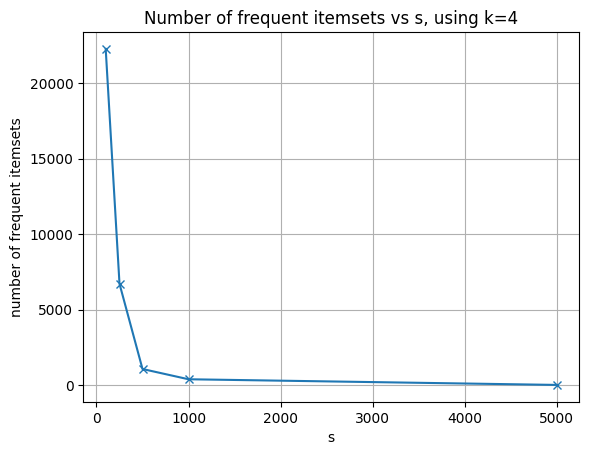

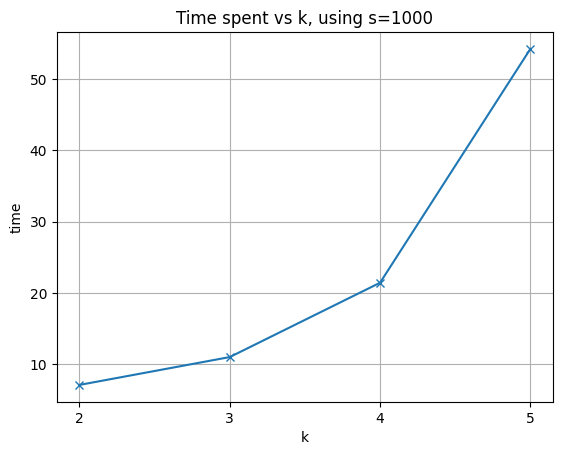

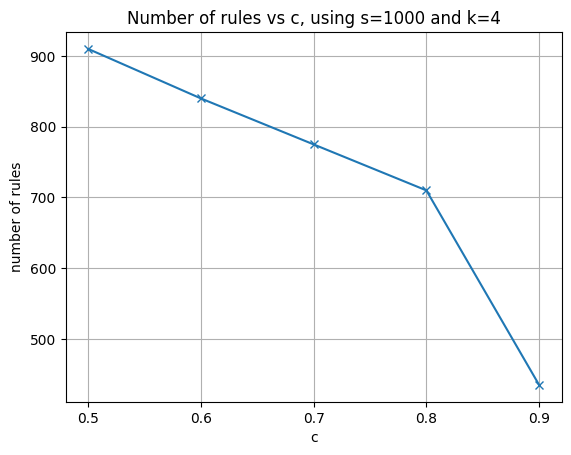

In [47]:
plt.plot(s_vals, n_frequent_itemsets, '-x')
plt.title('Number of frequent itemsets vs s, using k=4')
plt.xlabel('s')
plt.ylabel('number of frequent itemsets')
plt.grid()
plt.show()

plt.plot(k_vals, time_spent, '-x')
plt.title('Time spent vs k, using s=1000')
plt.xticks(k_vals)
plt.xlabel('k')
plt.ylabel('time')
plt.grid()
plt.show()

plt.plot(c_vals, n_rules, '-x')
plt.title('Number of rules vs c, using s=1000 and k=4')
plt.xticks(c_vals)
plt.xlabel('c')
plt.ylabel('number of rules')
plt.grid()
plt.show()


# Comment on the plots

By looking at the plots we can notice how:
- By using different thresholds the number of frequent itemsets decreases fast, in fact there is a sudden drop when we go from 100, to 250 and 500, and it soon gets to zero if we use s=5000
- If we change the value of k for finding frequent itemsets, the time to get to find the frequent itemsets using the A_Priori algorithm increases drastically, with an exponential trend
- By changing the value of confidence for mining rules, we can see how we keep less and less rule
    - However it is probably better to keep only rules with a high degree of confindence, since they will probably be more meaningful.